# D1211_WORK_김현우 
#### 악성 유방암 감지

[1] 모듈 로딩 및 데이터 준비 <HR>

In [1]:
# ===================================================================================================================================
# [1-1] 모듈 로딩
# ===================================================================================================================================

# 분석
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 머신러닝 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ===================================================================================================================================
# [1-2] 데이터 준비
# ===================================================================================================================================

FILE_NAME = '../Data/wdbc.csv'
dataDF = pd.read_csv(FILE_NAME)
wdbcDF = dataDF.copy()

[2] 이상치 함수 <hr>

In [2]:
# -------------------------------------------------------------
# 이상치 분석 및 선택적 제거
# -------------------------------------------------------------
def analysis_outlier(data, remove=False, target_col=None):
    
    '''
    이상치 분석 및 선택적 제거 함수
    
    data       : DataFrame - 분석할 데이터
    remove     : bool - True: 제거, False: 분석만
    target_col : str - 제거할 열 이름 (remove=True일 때 필수)
    '''
    # 숫자 데이터만 가져옴(error 방지)
    num_data = data.select_dtypes(include=[np.number])
    
    print("=== 이상치 분석 ===")
    for col in num_data.columns:
        
        # 사분위수
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr = q3 - q1

        # 하한/상한
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        
        # 이상치
        mask = (data[col] < lower) | (data[col] > upper)
        outliers = data[mask][col]
        
        upper_out = data[data[col] > upper][col]
        lower_out = data[data[col] < lower][col]
        
        # 출력
        print(f"【{col}】 범위: [{lower:.2f}, {upper:.2f}]")
        print(f"  이상치: {len(outliers)}개 (상한: {len(upper_out)}, 하한: {len(lower_out)})")
        # if len(outliers) > 0:
        #     print(f"  값: {sorted(outliers.values)}")

        # 제거
        if remove and col == target_col:
            before = len(data)
            cleanDF = data[(data[col] >= lower) & (data[col] <= upper)]
            after = len(cleanDF)
            print(f"  ✓ 제거됨: {before}행 → {after}행")

        print()

    return cleanDF if remove else None

[3] 데이터 확인 및 전처리 <HR>

In [3]:
# ===================================================================================================================================
# 기본 정보 (Basic Information)
# ===================================================================================================================================
# id                        : 샘플 식별 번호 (ID Number)
# diagnosis                 : 진단 결과 (M = Malignant 악성, B = Benign 양성)

# ===================================================================================================================================
# 세포 핵 평균 특징 (Mean Features)
# ===================================================================================================================================
# radius_mean               : 반경 평균 (중심에서 외곽까지의 거리들의 평균)
# texture_mean              : 질감 평균 (그레이스케일 값의 표준편차)
# perimeter_mean            : 둘레 평균
# area_mean                 : 면적 평균
# smoothness_mean           : 매끄러움 평균 (반경 길이의 국소적 변화)
# compactness_mean          : 다짐도 평균 ((둘레^2 / 면적) - 1.0)
# concavity_mean            : 오목함 평균 (윤곽의 오목한 부분의 심각도)
# concave_points_mean       : 오목한 점 평균 (윤곽의 오목한 부분의 수)
# symmetry_mean             : 대칭성 평균
# fractal_dimension_mean    : 프랙탈 차원 평균 ("해안선 근사" - 1)

# ===================================================================================================================================
# 세포 핵 표준오차 특징 (Standard Error Features)
# ===================================================================================================================================
# radius_se                 : 반경 표준오차
# texture_se                : 질감 표준오차
# perimeter_se              : 둘레 표준오차
# area_se                   : 면적 표준오차
# smoothness_se             : 매끄러움 표준오차
# compactness_se            : 다짐도 표준오차
# concavity_se              : 오목함 표준오차
# concave_points_se         : 오목한 점 표준오차
# symmetry_se               : 대칭성 표준오차
# fractal_dimension_se      : 프랙탈 차원 표준오차

# ===================================================================================================================================
# 세포 핵 최악/최대 특징 (Worst Features) 
# ===================================================================================================================================
# radius_worst              : 반경 최악값 (가장 큰 3개 값의 평균)
# texture_worst             : 질감 최악값
# perimeter_worst           : 둘레 최악값
# area_worst                : 면적 최악값
# smoothness_worst          : 매끄러움 최악값
# compactness_worst         : 다짐도 최악값
# concavity_worst           : 오목함 최악값
# concave_points_worst      : 오목한 점 최악값
# symmetry_worst            : 대칭성 최악값
# fractal_dimension_worst   : 프랙탈 차원 최악값

In [4]:
# ===================================================================================================================================
# [3-1] 데이터 확인 - 모든 컬럼들이 범주형
# ===================================================================================================================================
# 전체 데이터 확인
display(wdbcDF.head(3))

# 데이터 타입 확인
print(wdbcDF.info())    # 모든 컬럼들이 범주형 데이터   

# diagnosis 컬럼 확인
print(wdbcDF["diagnosis"].value_counts())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
# ===================================================================================================================================
# [3-2] 데이터 전처리
# ===================================================================================================================================
# 중복값, 결측치 확인
print(f"중복값 : {wdbcDF.duplicated().sum()}\n")    # 중복값 X
print(f"결측치 : {wdbcDF.isnull().sum().sum()}\n")  # 결측치 X

# 불필요한 컬럼 제거
if 'id' in wdbcDF.columns:
    wdbcDF.drop('id', axis=1, inplace=True)

중복값 : 0

결측치 : 0



[4] 인코딩 <hr>
diagnosis(진단 결과) 컬럼이 object 타입 → 인코딩 필요


In [6]:
lbEncoder = LabelEncoder()
wdbcDF['diagnosis'] = lbEncoder.fit_transform(wdbcDF['diagnosis'])

display(wdbcDF['diagnosis'])

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

[5] 피쳐(x)와 타겟(y) 분리 <hr>

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

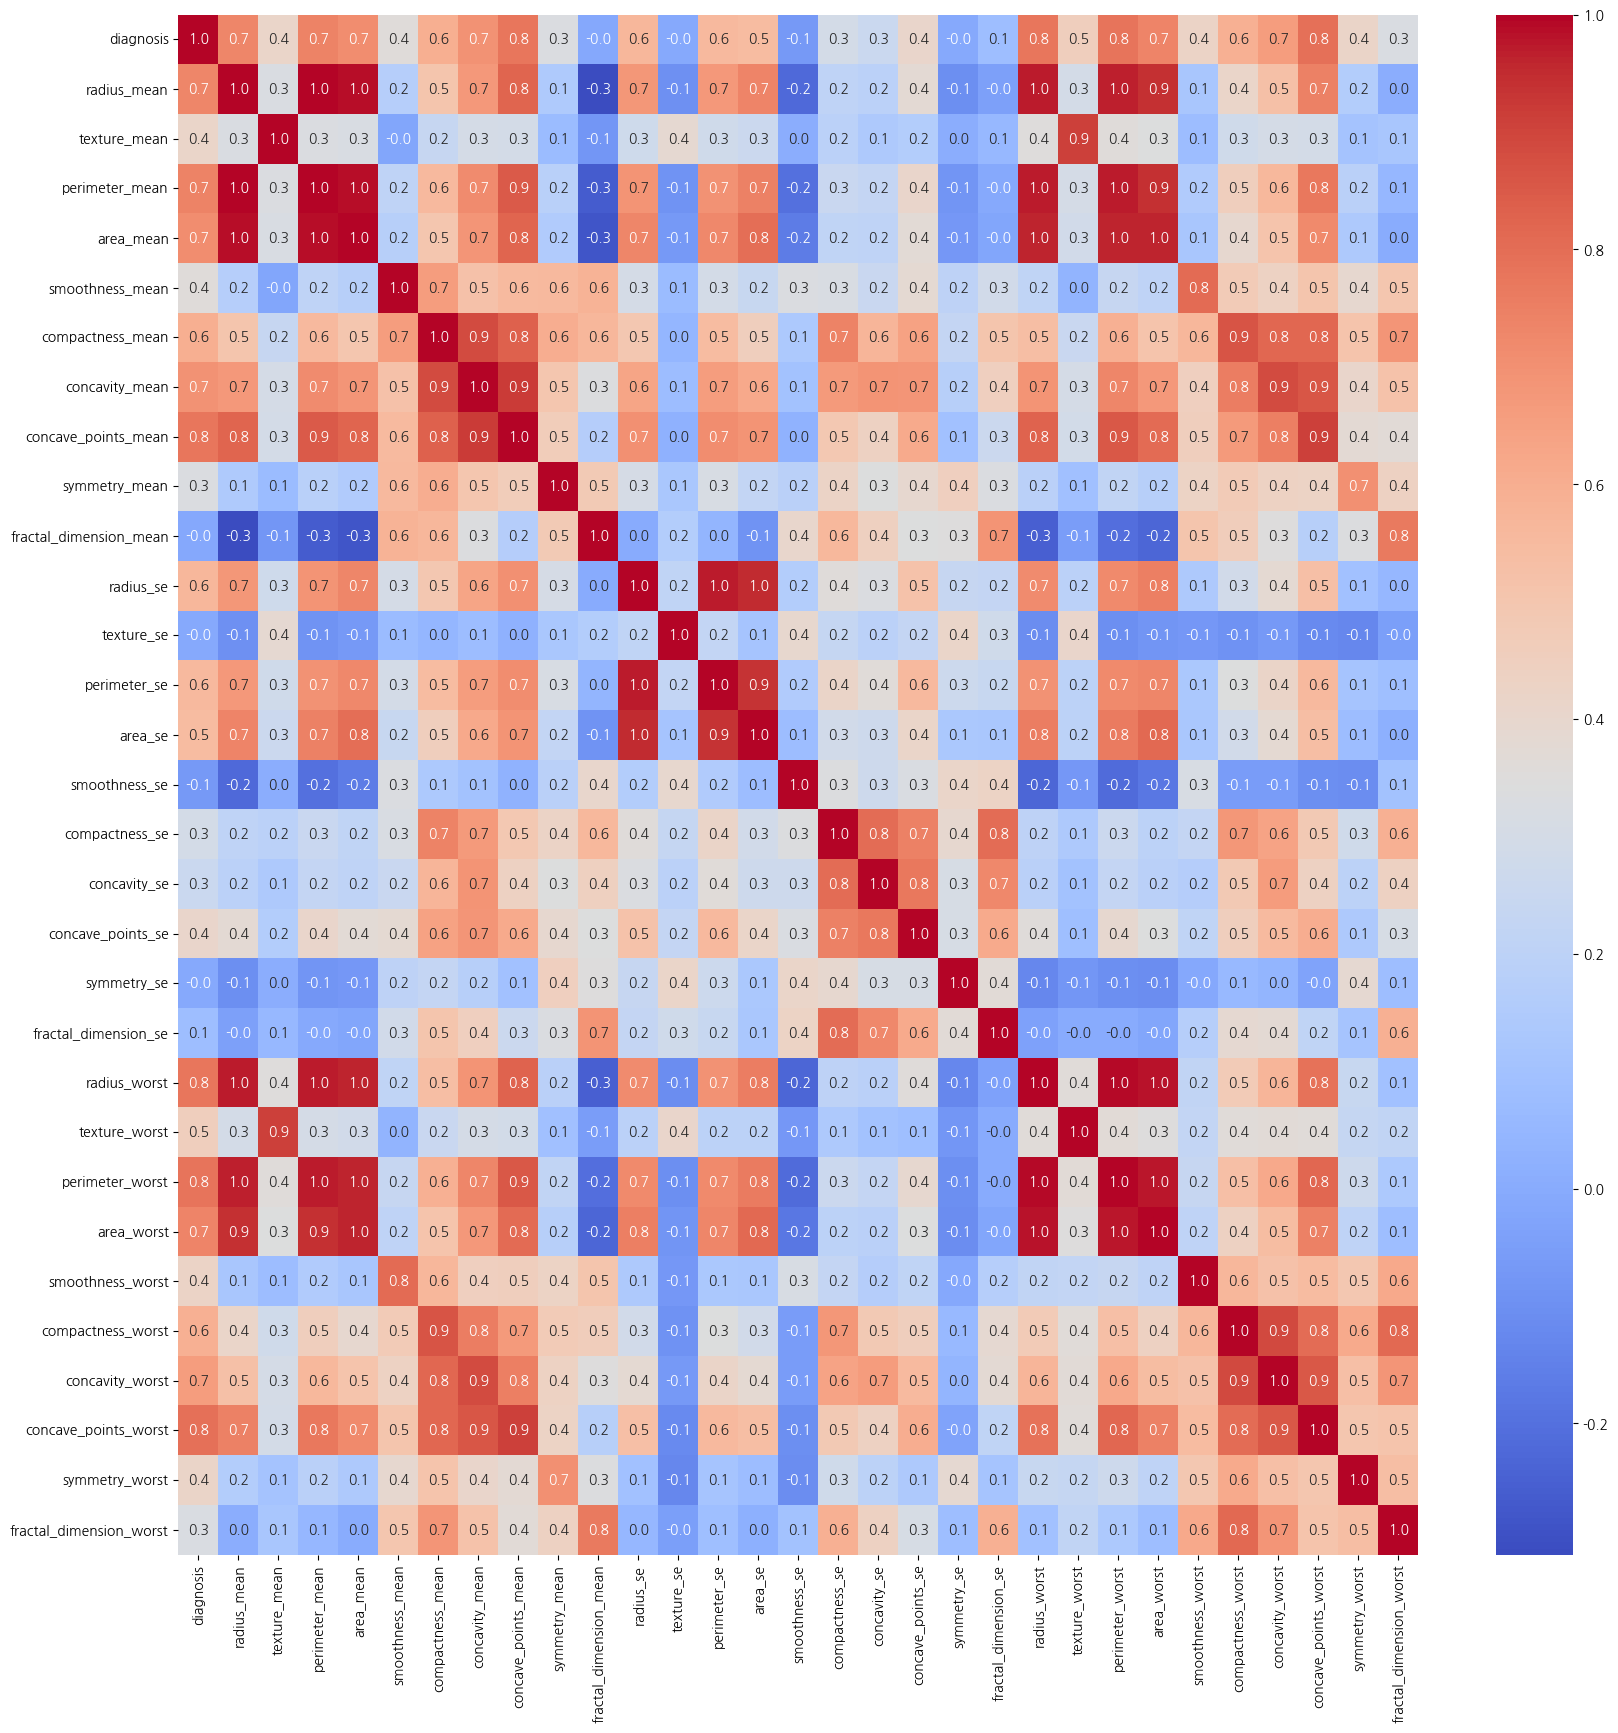

['radius_mean', 'perimeter_mean', 'area_mean', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave_points_worst']


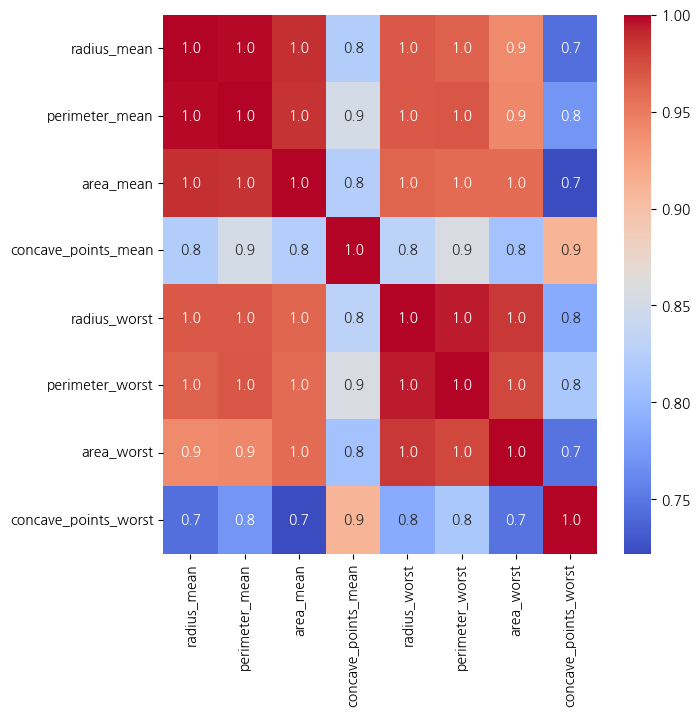

,radius_worst,concave_points_worst
0,25.380,0.2654
1,24.990,0.1860
2,23.570,0.2430
3,14.910,0.2575
4,22.540,0.1625
...,...,...
564,25.450,0.2216
565,23.690,0.1628
566,18.980,0.1418
567,25.740,0.2650


In [7]:
# ===================================================================================================================================
# [5-1] 타겟 분리 - 타겟은 diagnosis컬럼(악성, 양성)이 확실
# ===================================================================================================================================

targetSR = wdbcDF['diagnosis']
display(targetSR)

# ===================================================================================================================================
# [5-2] 상관관계 분석
# ===================================================================================================================================

# ======= 히트맵으로 상관관계 보기 =======
corr_matrix = wdbcDF.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.show()


# ======= 타겟 컬럼과 상관계수가 0.7 이상인 컬럼 이름만 뽑기 =======
corr_ = corr_matrix['diagnosis'].abs()
# print(corr_)

highCorr = corr_[corr_ >= 0.7].index.tolist()

if 'diagnosis' in highCorr:
    highCorr.remove('diagnosis')

print(highCorr)

# ======= 0.7 이상인 컬럼들끼리 상관계수 분석 =======
corrDF = wdbcDF[['radius_mean', 'perimeter_mean', 'area_mean', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave_points_worst']]
corr_matrix2 = corrDF.corr()

plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix2, annot=True, fmt='.1f', cmap='coolwarm')
plt.show()

# ======= 상관계수 분석 결과 =======
# radius mean, perimeter mean, area mean, 
# radius worst, perimeter worst, area worst 이 여섯 컬럼은 서로 상관계수가 1.0 
# 따라서 크기 컬럼 중 대표로 radius worst, 형태 컬럼 중 대표로 concave_points_worst 총 두 컬럼을 타겟 컬럼으로 사용하기로 함

# ===================================================================================================================================
# [5-3] 피쳐 분리
# ===================================================================================================================================

featureDF = wdbcDF[['radius_worst', 'concave_points_worst']]
display(featureDF)

# ===================================================================================================================================

[6] 피쳐 컬럼 이상치 처리 및 스케일링 <hr>

=== 이상치 분석 ===
【radius_worst】 범위: [4.34, 27.46]
  이상치: 17개 (상한: 17, 하한: 0)

【concave_points_worst】 범위: [-0.08, 0.31]
  이상치: 0개 (상한: 0, 하한: 0)



<Axes: ylabel='radius_worst'>

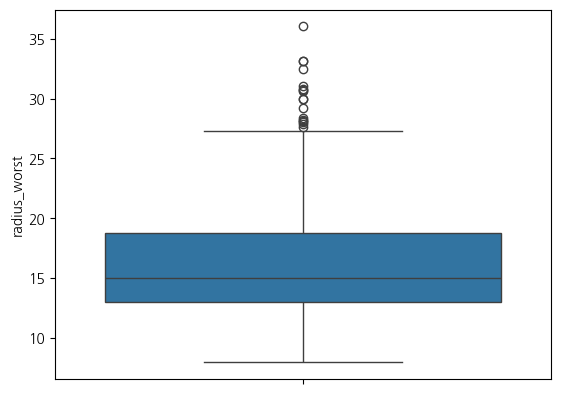

In [8]:
analysis_outlier(featureDF)

sns.boxplot(featureDF.radius_worst)

[7] 학습용 / 테스트용 데이터셋 분할 <hr>
(x: feature, y: target)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    featureDF,
    targetSR,
    random_state=42,
    test_size=0.2,
    stratify=targetSR)

print(f'[TRAIN] x_train:{x_train.shape},  y_train:{y_train.shape}')
print(f'[TEST]  x_test:{x_test.shape} ,  y_test:{y_test.shape}')

[TRAIN] x_train:(455, 2),  y_train:(455,)
[TEST]  x_test:(114, 2) ,  y_test:(114,)


[7] 배깅 - 랜덤포레스트 모델 생성 및 학습, 비교<hr>

In [ ]:
# ===================================================================================================================================
# 1. 초기모델 생성
# ===================================================================================================================================
rfModel = RandomForestClassifier(
    n_estimators=100,           # 나무 개수 
    max_depth=None,             # 최대 깊이 
    min_samples_split=2,        # 분할 최소 샘플
    min_samples_leaf=1,         # 리프 노드 최소 샘플
    random_state=42,            
    n_jobs=-1,                  
    class_weight='balanced'     
)

# ===================================================================================================================================
# 2. 초기모델 학습
# ===================================================================================================================================
rfModel.fit(x_train, y_train)

# ===================================================================================================================================
# 3. 초기모델 성능
# ===================================================================================================================================
print(f"랜덤포레스트 모델 score : {rfModel.score(x_test, y_test)}")

랜덤포레스트 모델 score : 0.9385964912280702


[7] 교차 검증 <hr>
StratifiedKFold

In [11]:
skf = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42)

crossVAL = cross_val_score(
    rfModel, 
    x_train, y_train,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1    
)   

print(f"fold별 교차검증 score : {crossVAL}")
print(f"평균                 : {crossVAL.mean():.4f}")
print(f"표준편차              : {crossVAL.std():.4f}")

fold별 교차검증 score : [0.93406593 0.97802198 0.92307692 0.9010989  0.95604396]
평균                 : 0.9385
표준편차              : 0.0266


[8] 하이퍼파라미터 튜닝 <hr>

In [17]:
# ===================================================================================================================================
# [8-1] test할 하이퍼파라미터셋
# ===================================================================================================================================

param_dist = {
    'n_estimators'     : [50, 100, 200, 300],    # 나무 개수
    'max_depth'        : [5, 10, 15, 20, None],  # 최대 깊이
    'min_samples_split': [2, 5, 10],             # 분할 최소 샘플
    'min_samples_leaf' : [1, 2, 4]}              # 리프 최소 샘플


# ===================================================================================================================================
# [8-2] best 하이퍼파라미터 찾기
# ===================================================================================================================================

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=10,      
    cv=skf,           
    scoring='accuracy',
)

random_search.fit(x_train, y_train)
print(f"최적 파라미터: {random_search.best_params_}")
print(f"최고 점수   : {random_search.best_score_:.4f}")

최적 파라미터: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
최고 점수   : 0.9429


[9] 최종 모델 생성 <hr>
최적의 하이퍼파라미터
- max_depth=5 
- min_samples_split=2
- n_estimators=200
- min_samples_leaf=4

In [13]:
# ===================================================================================================================================
# 1. 최종모델 생성
# ===================================================================================================================================
final_rfModel = RandomForestClassifier(
    **random_search.best_params_,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

# ===================================================================================================================================
# 2. 최종모델 학습
# ===================================================================================================================================
final_rfModel.fit(x_train, y_train)

# ===================================================================================================================================
# 3. 최종모델 성능
# ===================================================================================================================================

print(f"랜덤포레스트 모델 score : {final_rfModel.score(x_test, y_test)}")

랜덤포레스트 모델 score : 0.9473684210526315


[10] 예측 모델 생성 <hr>

In [14]:
print(featureDF)
print(targetSR)

     radius_worst  concave_points_worst
0          25.380                0.2654
1          24.990                0.1860
2          23.570                0.2430
3          14.910                0.2575
4          22.540                0.1625
..            ...                   ...
564        25.450                0.2216
565        23.690                0.1628
566        18.980                0.1418
567        25.740                0.2650
568         9.456                0.0000

[569 rows x 2 columns]
0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64


In [16]:
# ===================================================================================================================================
# 유방암 세포핵의 반경 최악값/오목한 점 최악값 ==> 유방암 예측
# ===================================================================================================================================

in_data = input("유방암 세포핵의 반경 최악값/오목한 점 최악값 입력(예: 25.3 0.26):").strip().split()
# print(f'new_data : {in_data}', '\n')

# DF 형식으로 저장
newDF = pd.DataFrame([in_data], columns=['radius_worst', 'concave_points_worst'])
# display(newDF)

# 예측 진행
pre_target = final_rfModel.predict(newDF)
proba_ = final_rfModel.predict_proba(newDF)  # 예측 확률

# 클래스 0, 1 확률
edible_prob = proba_[0][0] * 100      # 양성(0)일 확률
poisonous_prob = proba_[0][1] * 100   # 악성(1)일 확률

print(f"\n[예측 확률]")
print(f" 유방암 양성일 확률: {edible_prob}%")
print(f" 유방암 악성일 확률: {poisonous_prob}%")

result = '악성 (Malignant)' if pre_target[0] == 0 else '양성 (Benign)'

print(f'\n세포핵의 반경 최악값: {in_data[0]}, 오목한 점 최악값: {in_data[1]} → 유방암 {result} 입니다.')


[예측 확률]
 유방암 양성일 확률: 0.0%
 유방암 악성일 확률: 100.0%

세포핵의 반경 최악값: 25, 오목한 점 최악값: 0.2 → 유방암 양성 (Benign) 입니다.
